In this tutorial, we annotate cell type based on bulk RNA-seq reference data. To do that, the single cell RNA-seq data should be stored in a Seurat object, with @dr$tsne, @ident and @meta.data filled. 

We use super cell generated by lightbulb's Super_cell_creation. You can use other super cell matrix for input, but make sure that the coloumn of genes are in the same order as bulk samples, and row names indicate the cell id in Seurat object.

## loading data

In [7]:
devtools::load_all("/home/ahe/tools/Lightbulb")

Loading Lightbulb


In [2]:
# load Seurat object
load("Exp_Seurat_all10_180917.Rdata")

# load supercell data  
merging_out=readRDS(paste0("Exp_pseudoCell_nofilter.rds"))

# load reference bulk annotation
HVG=head(rownames(Exp_Seurat@hvg.info), 5000)

LLTE_Tcm_Tem=fread("reference_Data/LLTE Tcm Tem Expression File.csv",sep=",",header=T,data.table=F)
LLTE_Tcm_Tem=LLTE_Tcm_Tem[,-2]
TE_MP=fread("reference_Data/TE MP expression file.csv",sep=",",header=T,data.table=F)

# which gene to use
candidate_g=Reduce(intersect, list(LLTE_Tcm_Tem$NAME,TE_MP$DESCRIPTION))
common_gene=intersect(candidate_g,HVG)

## prepare input
  
bulk_list is a 2 level list:  
  
bulk_list  
---sample_set1  
------sample1.1=data.frame (each row is one replicate, each column is a gene)  
------sample1.2=vector (if no replicate)  
---sample_set2  
------sample2.1=data.frame  
------sample2.2=data.frame  
------sample2.3=data.frame  
  
all the sample dataframe or vector should have the same gene order

In [3]:
bulk_list=list(Spleen_D7=list(TE=TE_MP$D7_TE[match(common_gene,TE_MP$DESCRIPTION)],
                              MP=TE_MP$D7_MP[match(common_gene,TE_MP$DESCRIPTION)]),
               Spleen_D30=list(LLE=t(LLTE_Tcm_Tem[match(common_gene,LLTE_Tcm_Tem$NAME),2:3]),
                               TEM=t(LLTE_Tcm_Tem[match(common_gene,LLTE_Tcm_Tem$NAME),4:5]),
                               TCM=t(LLTE_Tcm_Tem[match(common_gene,LLTE_Tcm_Tem$NAME),6:7])))

#normalize bulk list, and format the data to right structure
bulk_list=bulk_list_normalize(bulk_list)

In [4]:
#select cells for mapping in Seurat object
tag_cell_for_all_cells=which(Exp_Seurat@meta.data$tissue == "Spleen")

#select super cells center in all candidate cells
tag_cell=as.numeric(rownames(merging_out)) %in% tag_cell_for_all_cells

#create the super cell matrix
sc_mat=merging_out[tag_cell,common_gene]

### data processing and general correlation

In [5]:
dataset=data_preprocessing(bulk_list,sc_mat,common_gene)

Test whether the bulk sample set classification make sense. In the following plot, the color bar on the top and left indicate the bulk sample sets. Bulk samples shoule be highly similar within one set.

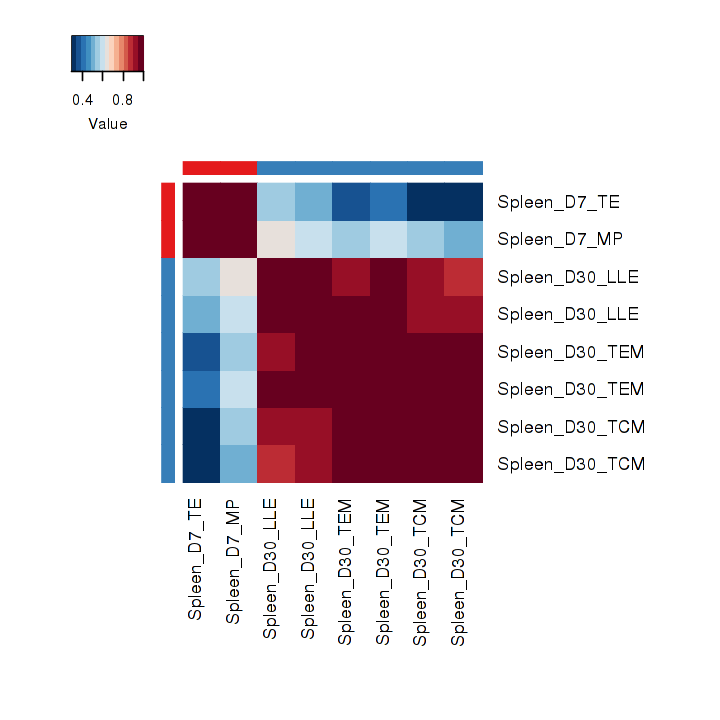

In [8]:
options(repr.plot.width=6, repr.plot.height=6)
plot_bulk_bulk_cor(dataset)

We need to know how similar are the super cells compare to bulk sets. We can plot the correlation distribution by **plot_SC_sampleSet_cor_distribution**, and set threshold to pick the right most peak

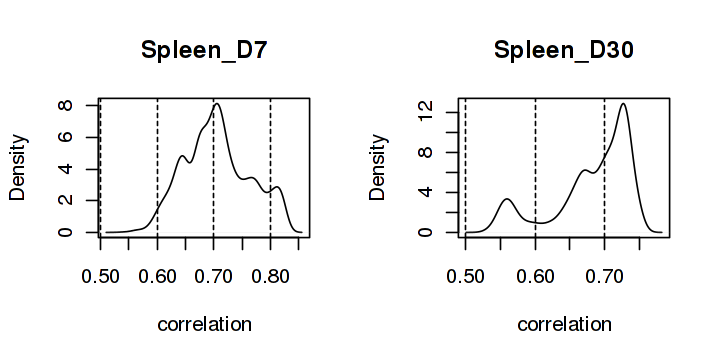

In [9]:
options(repr.plot.width=6, repr.plot.height=3)
par(mfrow=c(1,2))
plot_SC_sampleSet_cor_distribution(dataset)

it seems that 0.71 is a good threshold for both bulk sets.

In [10]:
threshold=c(0.71,0.71)

To futhur illustrate how the correlation distribute, we can plot the correlation on TSNE by using **plot_SC_sampleSet_cor_TSNE**. By setting the *thresholds* parameter, all cells fall below thresholds in correlation will be shown as gray

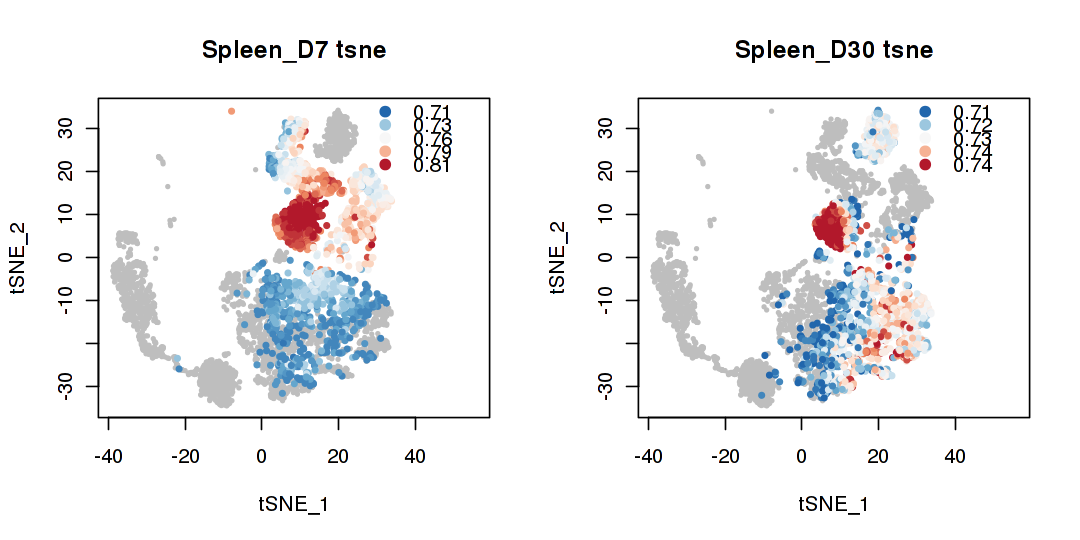

In [11]:
options(repr.plot.width=9, repr.plot.height=4.5)
par(mfrow=c(1,2))
plot_SC_sampleSet_cor_TSNE(dataset,Exp_Seurat,thresholds = threshold,color_contrast=1.5)

### 2nd correlation
With the *threshold* picked, we can run the 2nd round of correlation to identify the cell types.

In [15]:
dataset=secondary_cor(dataset,threshold)

We can plot the annotation on TSNE by **running plot_group_annotation_TSNE**

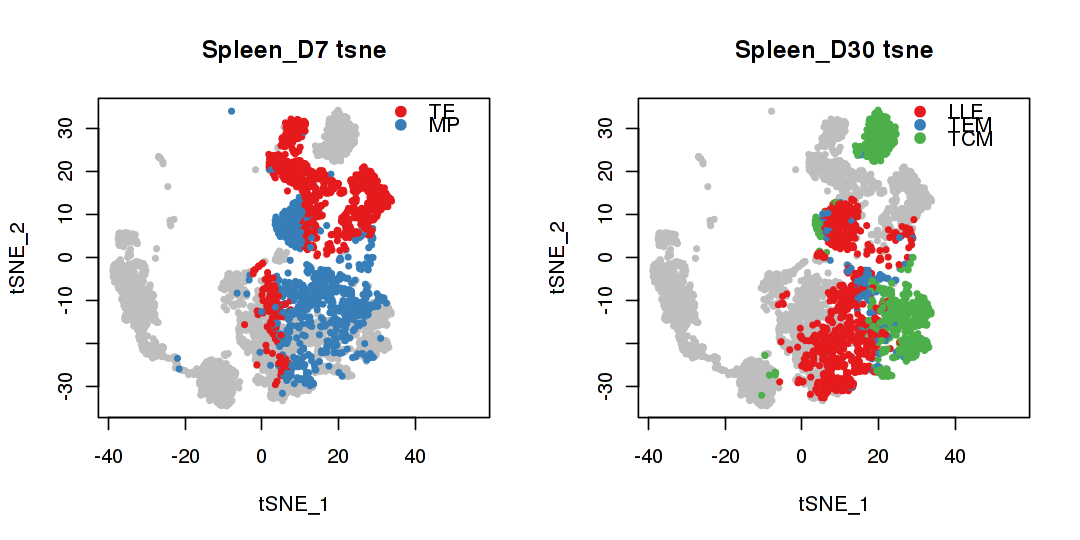

In [16]:
options(repr.plot.width=9, repr.plot.height=4.5)
par(mfrow=c(1,2))
plot_group_annotation_TSNE(dataset,Exp_Seurat)

We can also plot the score for each sample in their corresponding sample set with **plot_SC_sampleSet_cor_2nd_TSNE**

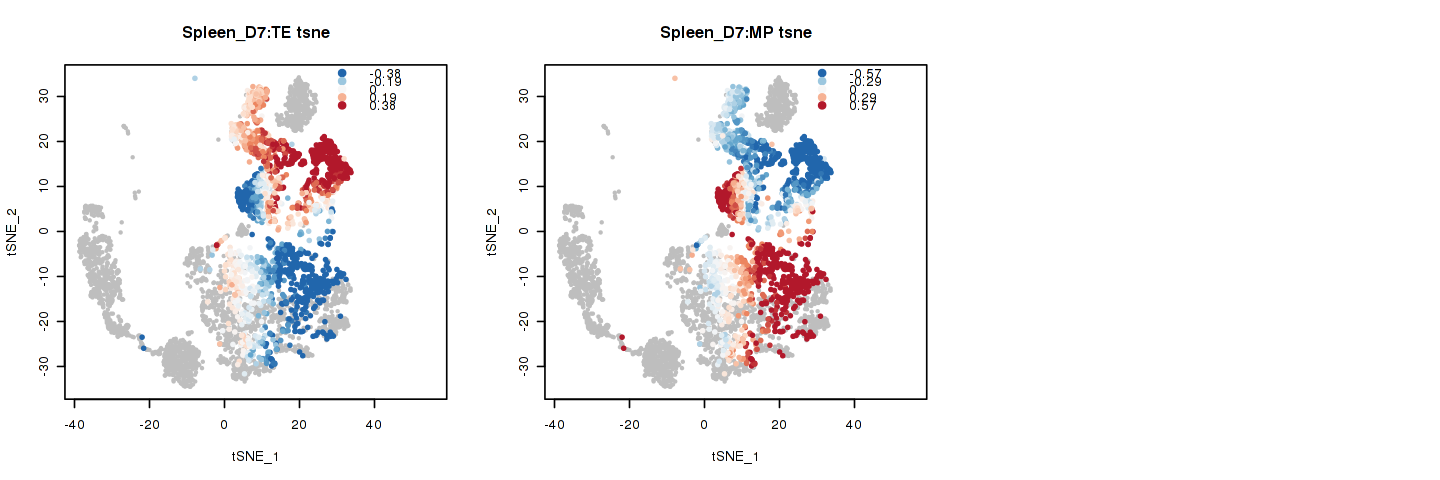

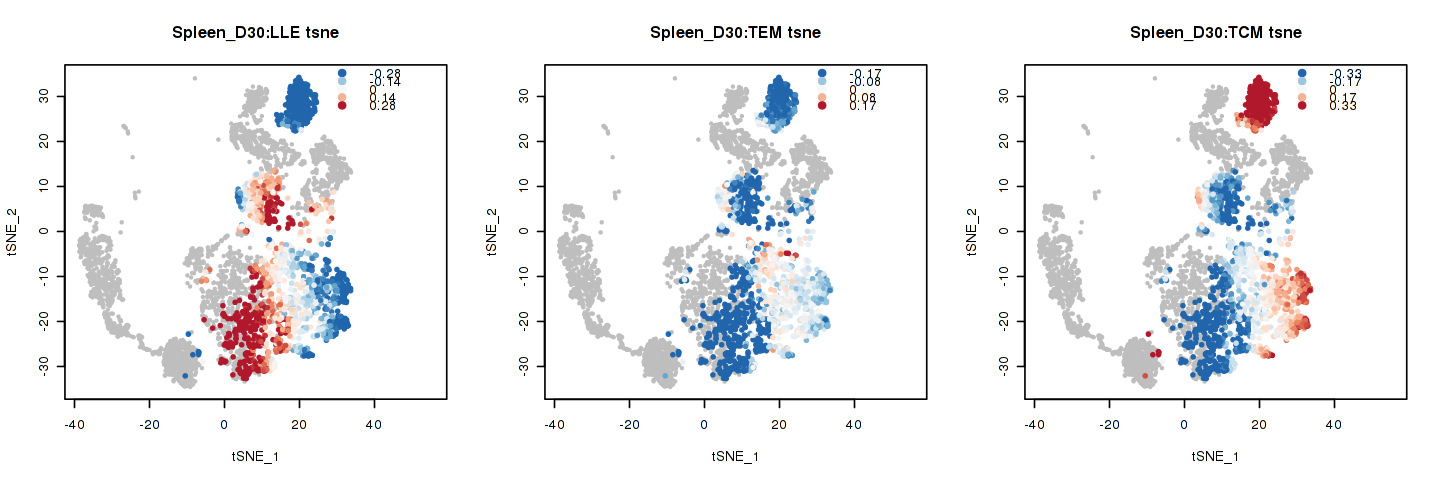

In [17]:
options(repr.plot.width=12, repr.plot.height=4)
par(mfrow=c(1,3))
plot_SC_sampleSet_cor_2nd_TSNE(dataset,Exp_Seurat,plot_sets=1)
par(mfrow=c(1,3))
plot_SC_sampleSet_cor_2nd_TSNE(dataset,Exp_Seurat,plot_sets=2)

### match bulk annotation with scRNA groups (across time)
We can furthur conduct cross analysis between annotated cells and the clustering result (stored in Exp_Seurat@ident) and other metadata (stored in Exp_Seurat@meta.data)  
Because we were using the super-cells for annotation, to annotate the single cells we need to label them according to clusters. We can use **metadata_reprocessing** to get the cells that's relevant for annotation, for example, all the spleen cells in this data set. This function will also store the metadata information into the *dataset* object.

In [18]:
dataset=metadata_reprocessing(dataset,Exp_Seurat,relavant_cells = which(Exp_Seurat@meta.data$tissue == "Spleen"))

With metadata preocessing done. We can annoate the single cells with the bulk annotation by using **dataset**.

In [19]:
dataset=celltype_annotation_by_cluster(dataset,min_percent = 0.3)

In [20]:
summary(dataset)

                     Length Class      Mode     
bulk_list               2   -none-     list     
bulk_list_centered      2   -none-     list     
bulk_df                 2   -none-     list     
bulk_df_centered        2   -none-     list     
sample_set_mean      9096   -none-     numeric  
sc_mat               4548   data.frame list     
SC_sampleSet_cor     8930   -none-     numeric  
bulk_bulk_cor          64   -none-     numeric  
replicate_df            2   -none-     list     
sc_metadata            11   data.frame list     
SC_sampleSet_cor_2nd    2   -none-     list     
celltype_assignment     2   data.frame list     
cluster_annotation     23   -none-     character

*dataset* object explained:<br>
*dataset\$bulk_xx* & *dataset\$replicate\_df* stored the bulk RNA-seq data <br>
*dataset\$sample_set_mean* stored the mean expression of each sample set <br>
*dataset\$sc_mat* stored the super-cell matrix <br>
*dataset\$SC_sampleSet_cor* stored the 1st super-cell sample set correlation <br>
*dataset\$bulk_bulk_cor* stored the correlation between bulk samples <br>
*dataset\$sc_metadata* stored the metadata for super-cell <br>
*dataset\$SC_sampleSet_cor_2nd* stored the 2nd super-cell bulk sample correltion within each sample set <br>
*dataset\$celltype_assignment* stored the cell type assignment for each super cell <br>
*dataset\$cluster_annotation* stored the new bulk annotated name for each cluster in Seurat@ident <br> 

### some additional plotting

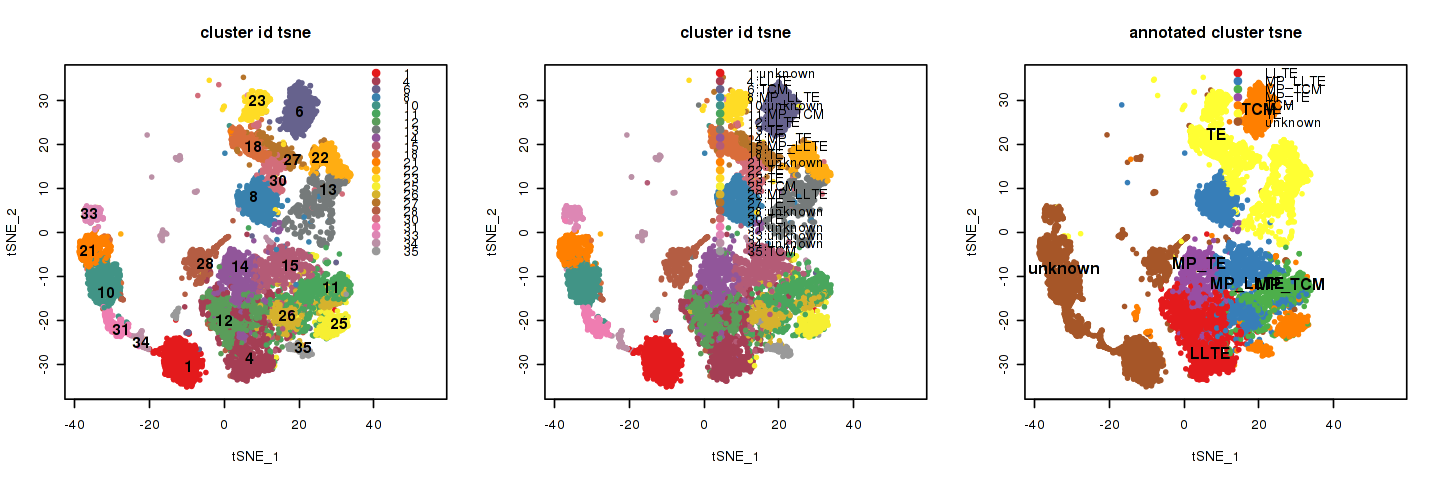

In [14]:
#options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,3))
identMatch=names(dataset$cluster_annotation)
names(identMatch)=names(dataset$cluster_annotation)
plot_scMeta_NotOnlySuperCell_byIdent(dataset,Exp_Seurat,identMatch = identMatch,main="cluster id",addtext=T)

identMatch=paste0(names(dataset$cluster_annotation),":",dataset$cluster_annotation)
names(identMatch)=names(dataset$cluster_annotation)
plot_scMeta_NotOnlySuperCell_byIdent(dataset,Exp_Seurat,identMatch = identMatch,main="cluster id",addtext=F)

plot_scMeta_NotOnlySuperCell_byIdent(dataset,Exp_Seurat,main="annotated cluster",addtext=T)

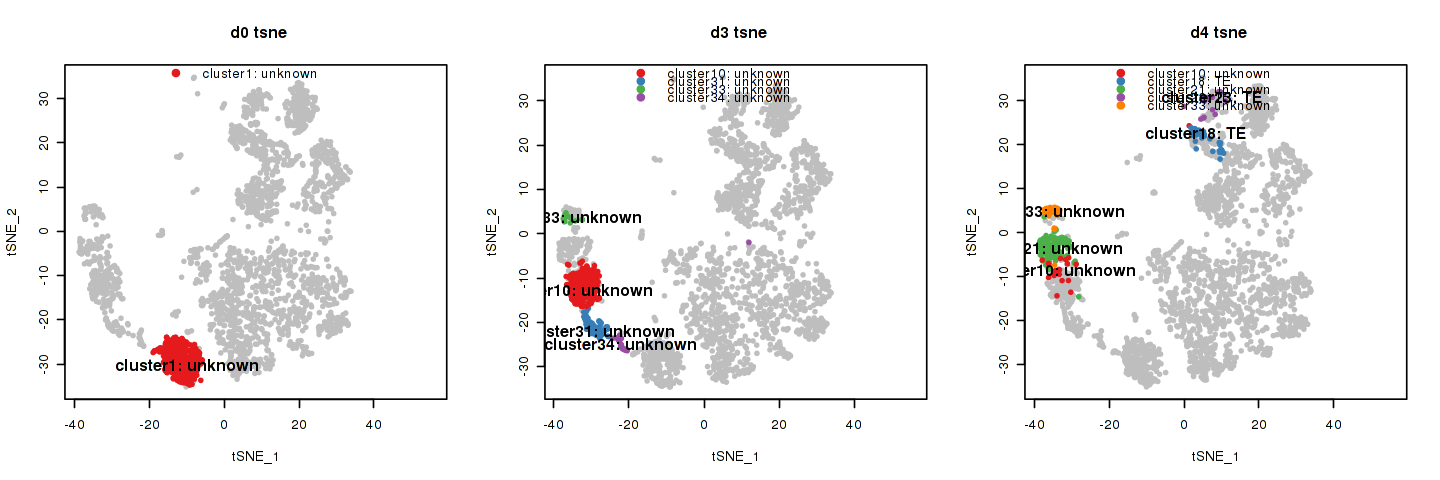

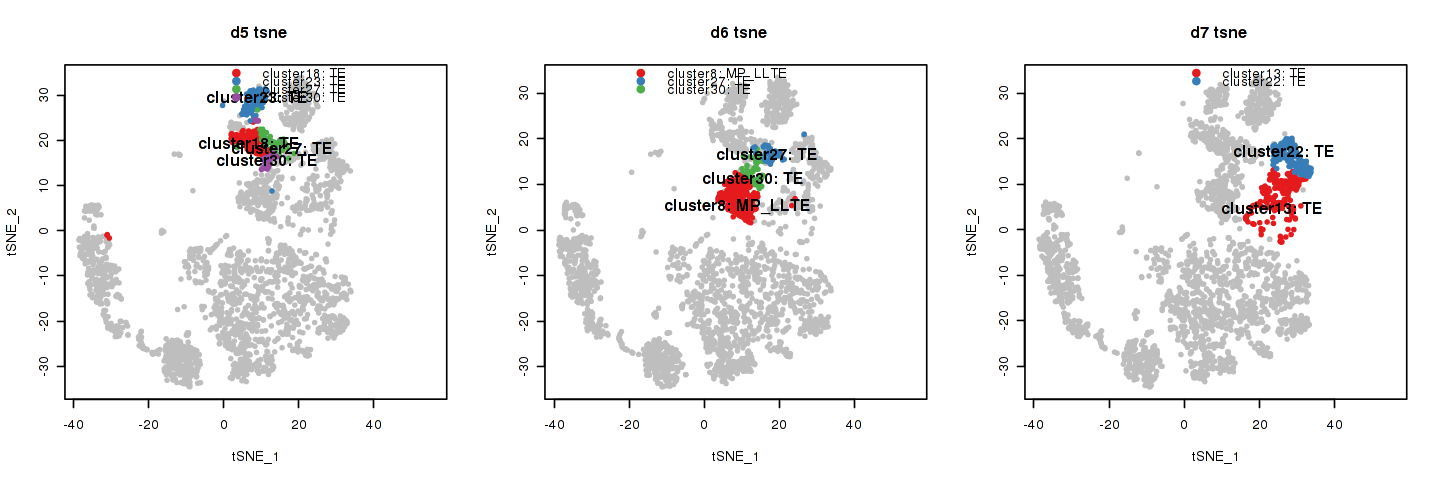

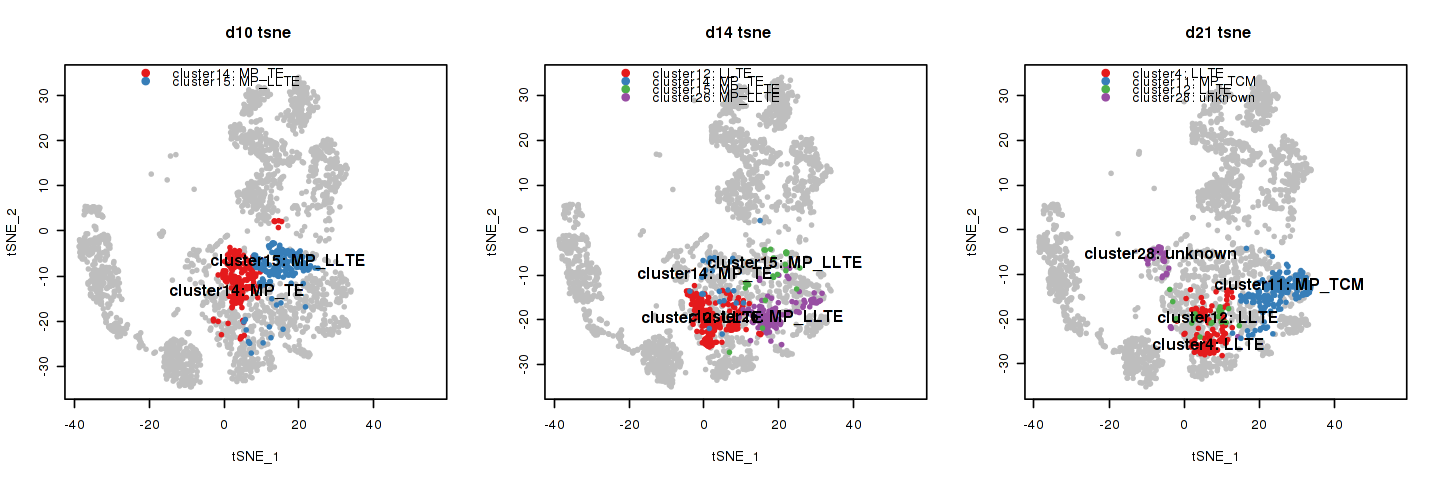

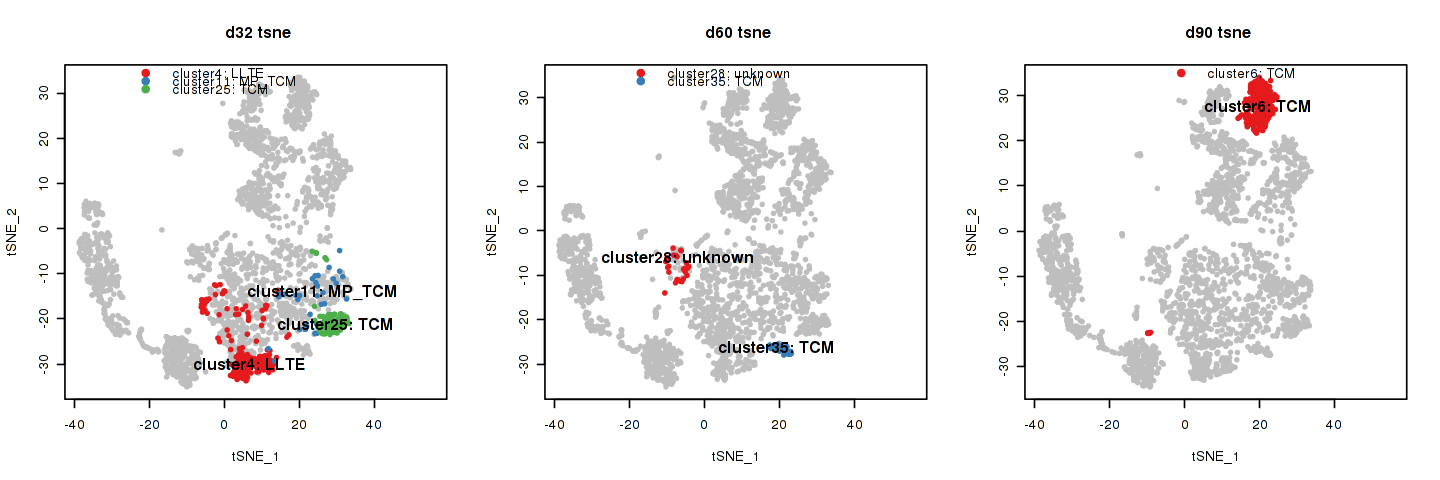

In [15]:
par(mfrow=c(1,3))
identMatch=paste0("cluster",names(dataset$cluster_annotation),": ",dataset$cluster_annotation)
names(identMatch)=names(dataset$cluster_annotation)
plot_scMeta_NotOnlySuperCell_by_category(dataset,Exp_Seurat,identMatch)